In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm
import glob

In [172]:
def gauß(x, mu, std, a):
    return (a/np.sqrt(2*np.pi*std**2))*np.exp(-((x-mu)**2)/2*std**2)

def log_norm(x, m, s, a):
    return (a/np.sqrt(2*np.pi)*s*x)*np.exp(-((np.log(x)-m**2)/2*s**2))

def rayleigh(x, mu, std):
    return (x/std**2)*np.exp(-(x-mu**2)/2*std**2)


def draw_quantile(data, quantile, linestyles=None, ax=None):
    if linestyles:
        for idx,q in enumerate(quantile):
            plt.axvline(x=np.quantile(data, q), color='k', label=f'{q*100}%', linestyle=linestyles[idx]) 
    else:
        for q in quantile:
            plt.axvline(x=np.quantile(data, q), color='k', label=f'{q*100}%')
            
def plot_cdf(data, end=1, num=10, plot=True):
    steps = np.linspace(0, end, num)
    data_mat, steps_mat = np.meshgrid(data, steps)
    cdf = np.array(list(map(np.quantile, data_mat, steps)))
    if plot: plt.plot(cdf, steps*100)
    return cdf, steps

def hist_cdf_plot(data, suptitle, bins, end=0.98, jitter_start=0, jitter_end=0.98):
    median = round(data.median(), 1) # median
    minimum = round(data.min(), 1)
    end_quant = round(np.quantile(data,end), 2)
    jit_start_quant = round(np.quantile(data,jitter_start), 2)
    jit_end_quant = round(np.quantile(data,jitter_end), 2)
    
    fig, ax = plt.subplots(1, 2, figsize=(15,7.5))
    
    fig.suptitle(suptitle)
    
    ax[0].hist(data, bins=bins, alpha=0.5, label='frequency') # histogram
    ax[0].axvline(x=median, color='k', linestyle='--', label=f'median {median}ms') # draw median
#     ax[0].axvline(x=minimum, color='k', linestyle=':', label=f'min {minimum}ms') # draw Min
#     ax[0].axvline(x=end_quant, color='k', linestyle='dashdot', label=f'quantile({end}) {end_quant}ms') # draw ninety_perc
    ax[0].legend(loc='upper left')
    ax[0].set_title('Histogramm')
    ax[0].set_xlabel('time [ms]')
    ax[0].set_ylabel('Frequency')
    # set grid ticks
    ax[0].yaxis.set_major_locator(MultipleLocator(250))
    ax[0].xaxis.set_major_locator(MultipleLocator(5))
    # minors relative to majors
    ax[0].xaxis.set_minor_locator(AutoMinorLocator(5))
    ax[0].yaxis.set_minor_locator(AutoMinorLocator(5))
    ax[0].grid(which='major')
    ax[0].grid(which='minor', linestyle=':')


    cdf, steps = plot_cdf(data, end=end, num=1000, plot=True) # compute CDF
    sub_window = (cdf>=jit_start_quant) & (cdf<=jit_end_quant) # subwindow to fill area under curve
    ax[1].fill_between(cdf[sub_window], steps[sub_window]*100,
                      color='gray', alpha=0.5, hatch=None, edgecolor=None,
                       label=f'Jitter [{jitter_start*100}%, {jitter_end*100}%] {round(jit_end_quant-jit_start_quant,1)}ms')
    
    ax[1].axvline(x=jit_start_quant, color='k', linestyle='--',
                  label=f'{jitter_start*100}% {jit_start_quant}ms') # draw median
    
    ax[1].axvline(x=jit_end_quant, color='k', linestyle='dashdot',
                  label=f'{jitter_end}% {jit_end_quant}ms') # draw ninety_perc
    
    ax[1].legend(loc='upper center')
    ax[1].set_title('CDF')
    ax[1].set_xlabel('time [ms]')
    ax[1].set_ylabel('Probability [%]')
    # set grid ticks
    ax[1].yaxis.set_major_locator(MultipleLocator(20))
    ax[1].xaxis.set_major_locator(MultipleLocator(2))
    # minors relative to majors
    ax[1].xaxis.set_minor_locator(AutoMinorLocator(4))
    ax[1].yaxis.set_minor_locator(AutoMinorLocator(4))
    ax[1].grid(which='major')
    ax[1].grid(which='minor', linestyle=':')
    return fig, ax

## Ethernet

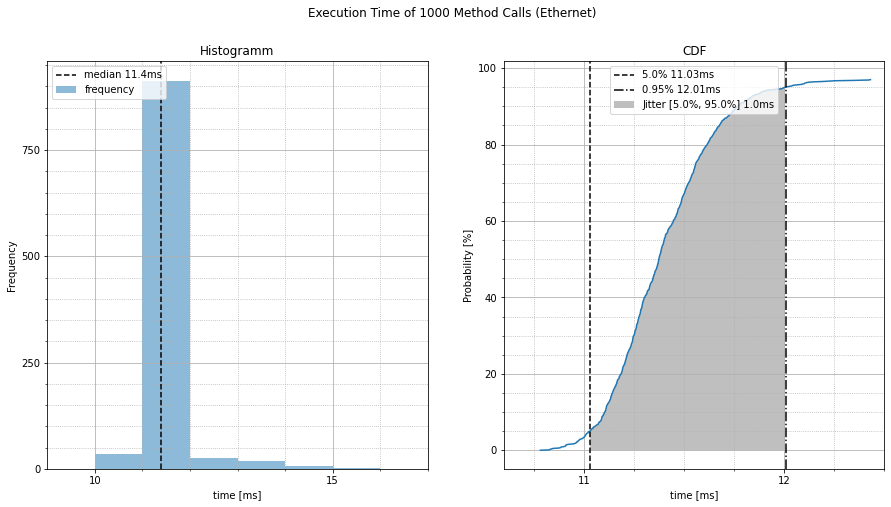

In [173]:
df_method = pd.read_csv('ethernet_method_cycles_1000_delay_0.csv')
method_call_ms = df_method['method_call']*10**(-6) # [ms]
bins = np.arange(0, 40, 1)
suptitle = f'Execution Time of {len(method_call_ms)} Method Calls (Ethernet)'
fig, ax = hist_cdf_plot(method_call_ms, suptitle, bins, end=0.97, jitter_start=0.05, jitter_end=0.95)
ax[0].axis(xmin=9, xmax=17)
ax[1].axis(xmin=10.6, xmax=12.5)
ax[1].xaxis.set_major_locator(MultipleLocator(1))
plt.show()

(0.0, 40.0, 0.0, 1.0)

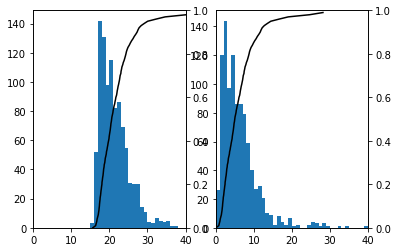

In [69]:
fig, ax = plt.subplots(1,2)

method_jitter = method_call_ms - method_call_ms.min()
bins = range(0,75,1)
ax[1].hist(method_jitter, bins=bins)

cdf_prob = np.arange(0, 1, 0.01)
cdf_jitter = np.zeros(cdf_prob.shape)
for idx, prob in enumerate(cdf_prob):
    #print(prob)
    cdf_jitter[idx] = np.quantile(method_jitter, prob)

ax2 = ax[1].twinx()

ax2.plot(cdf_jitter, cdf_prob, color='k')
ax2.axis(xmin=0, xmax=40, ymin=0, ymax=1)

bins = range(0,75,1)
ax[0].hist(method_call_ms, bins=bins)

cdf_delay = np.zeros(cdf_prob.shape)
for idx, prob in enumerate(cdf_prob):
    cdf_delay[idx] = np.quantile(method_call_ms, prob)

ax2 = ax[0].twinx()
ax2.plot(cdf_delay, cdf_prob, color='k')
ax2.axis(xmin=0, xmax=40, ymin=0, ymax=1)

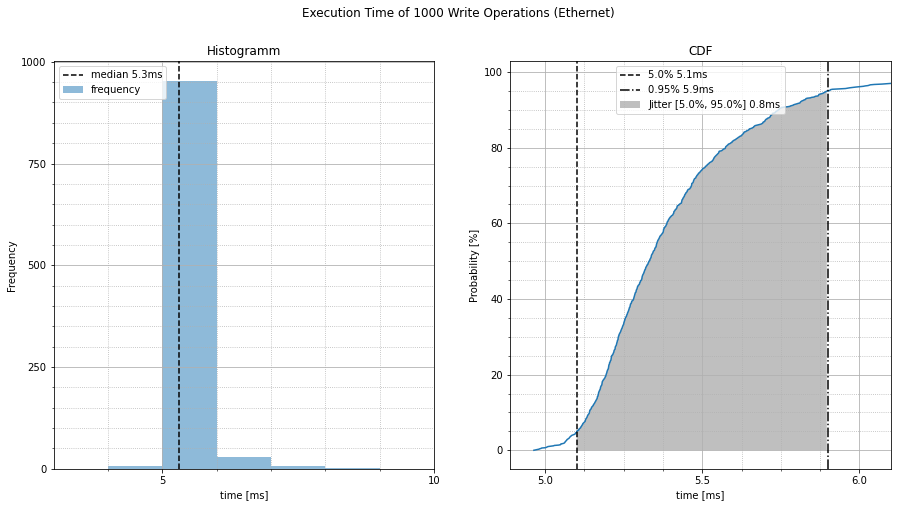

In [174]:
df_write = pd.read_csv('ethernet_write_value_cycles_1000_delay_0.csv')
write_val_ms = df_write['write_value']*10**(-6) # [ms]
bins = np.arange(0, 25, 1)
suptitle = f'Execution Time of {len(write_val_ms)} Write Operations (Ethernet)'
fig, ax = hist_cdf_plot(write_val_ms, suptitle, bins, end=0.98, jitter_start=0.05, jitter_end=0.95)
ax[0].axis(xmin=3, xmax=10)
ax[1].axis(xmax=6.1)
ax[1].xaxis.set_major_locator(MultipleLocator(0.5))
plt.show()

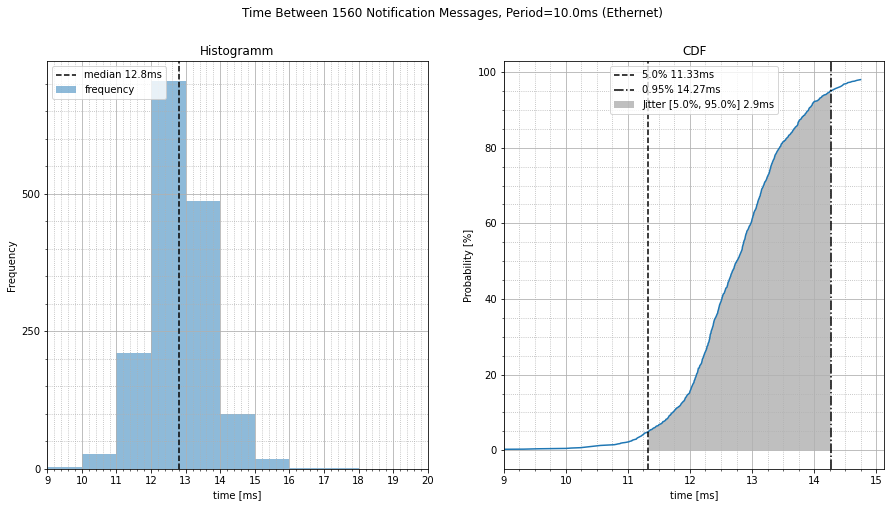

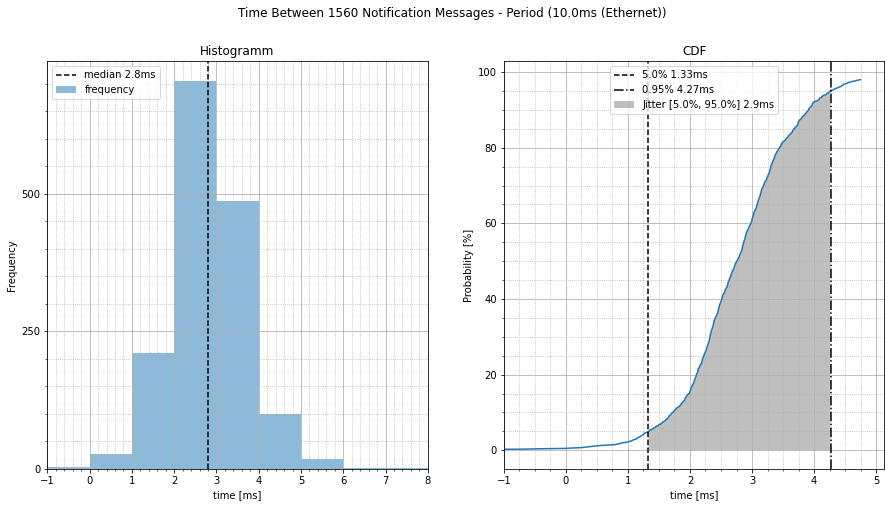

In [175]:
df_sub = pd.read_csv('ethernet_subscription_duration_20_period_10_changeInt_10_queuesize_1.csv')
notification_ms = df_sub['datachange_notifications']*10**(-6)# [ms]
period = df_sub['period'][0]
bins = np.arange(0, 30, 1)

suptitle = f'Time Between {len(notification_ms)} Notification Messages, Period={period}ms (Ethernet)'
fig, ax = hist_cdf_plot(notification_ms, suptitle, bins, end=0.98, jitter_start=0.05, jitter_end=0.95)
ax[0].axis(xmin=9, xmax=20)
ax[1].axis(xmin=9)
ax[0].xaxis.set_major_locator(MultipleLocator(1))
ax[1].xaxis.set_major_locator(MultipleLocator(1))

bins = np.arange(-5, 30, 1)
notification_ms = df_sub['datachange_notifications']*10**(-6)-df_sub['period']
suptitle = f'Time Between {len(notification_ms)} Notification Messages - Period ({period}ms (Ethernet))'
fig2, ax2 = hist_cdf_plot(notification_ms, suptitle, bins, end=0.98, jitter_start=0.05, jitter_end=0.95)
ax2[0].axis(xmin=-1, xmax=8)
ax2[1].axis(xmin=-1)
ax2[0].xaxis.set_major_locator(MultipleLocator(1))
ax2[1].xaxis.set_major_locator(MultipleLocator(1))

# WiFi

**write operations**

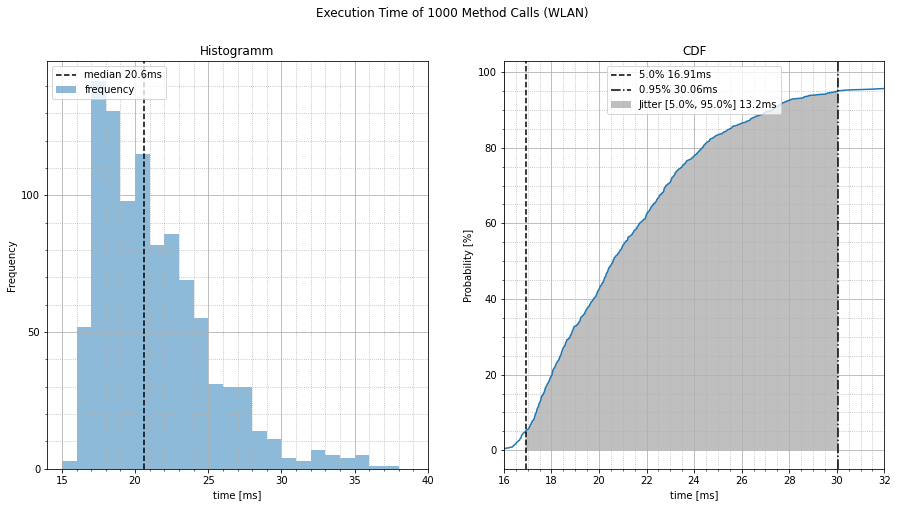

In [177]:
df_method = pd.read_csv('wlan_method_cycles_1000_delay_0.csv')
method_call_ms = df_method['method_call']*10**(-6) # [ms]
bins = np.arange(0, 40, 1)

suptitle = f'Execution Time of {len(method_call_ms)} Method Calls (WLAN)'
fig, ax = hist_cdf_plot(method_call_ms, suptitle, bins, end=0.98, jitter_start=0.05, jitter_end=0.95)
ax[0].axis(xmin=14, xmax=40)
ax[1].axis(xmin=16, xmax=32)
ax[0].yaxis.set_major_locator(MultipleLocator(50))

**method calls**

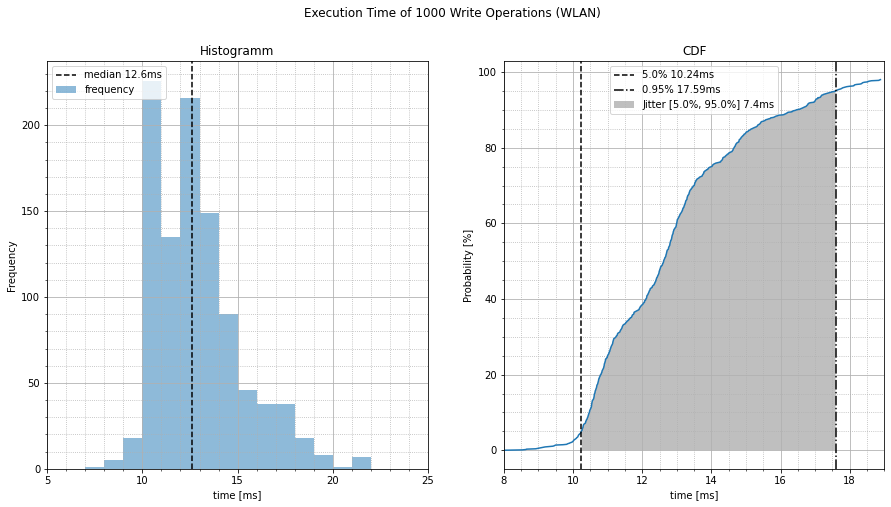

In [178]:
df_write = pd.read_csv('wlan_write_value_cycles_1000_delay_0.csv')
write_val_ms = df_write['write_value']*10**(-6) # [ms]
bins = np.arange(0, 25, 1)

suptitle = f'Execution Time of {len(write_val_ms)} Write Operations (WLAN)'   
fig, ax = hist_cdf_plot(write_val_ms, suptitle, bins, end=0.98, jitter_start=0.05, jitter_end=0.95)
ax[0].axis(xmin=5, xmax=25)
ax[1].axis(xmin=8, xmax=19)
ax[0].yaxis.set_major_locator(MultipleLocator(50))

**subscriptions**

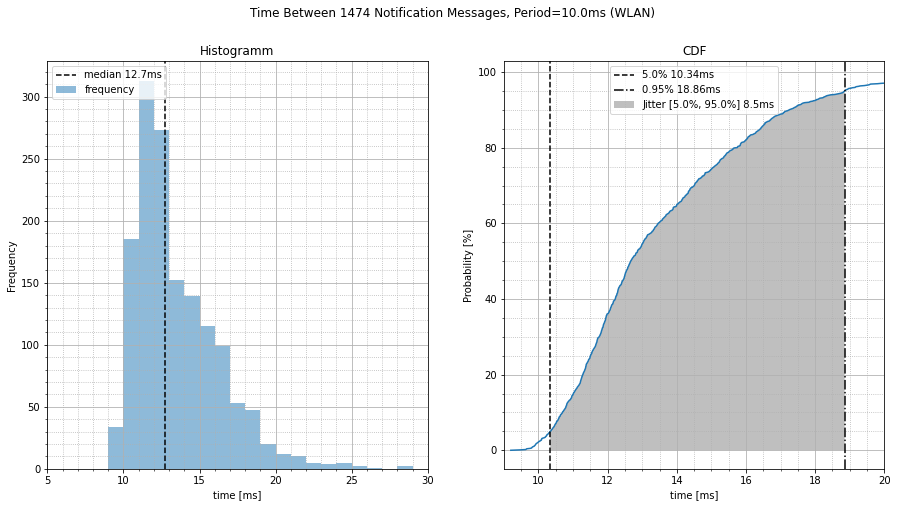

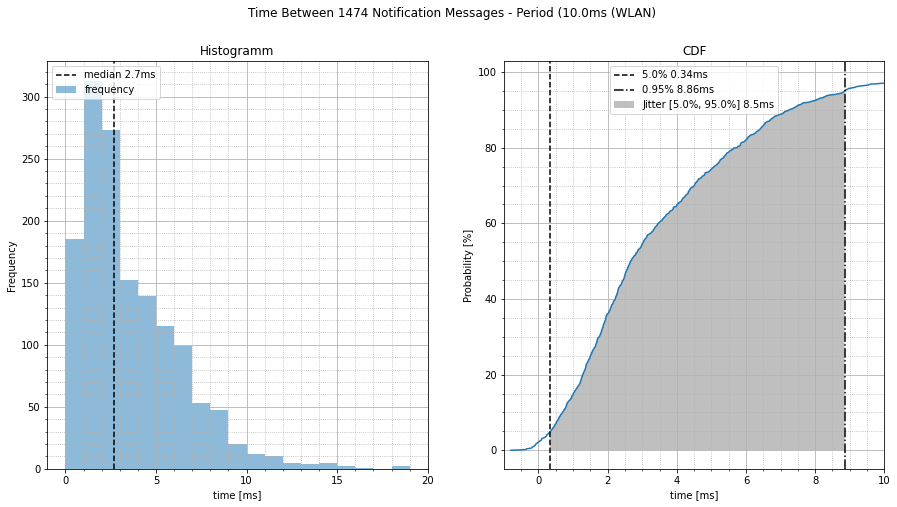

In [181]:
df_sub = pd.read_csv('wlan_subscription_duration_20_period_10_changeInt_10_queuesize_1.csv')

notification_ms = df_sub['datachange_notifications']*10**(-6)# [ms]
period = df_sub['period'][0]
bins = np.arange(0, 60, 1)
suptitle = f'Time Between {len(notification_ms)} Notification Messages, Period={period}ms (WLAN)'
fig, ax = hist_cdf_plot(notification_ms, suptitle, bins, end=0.98, jitter_start=0.05, jitter_end=0.95)
ax[0].axis(xmin=5, xmax=30)
ax[1].axis(xmin=9, xmax=20)
ax[0].yaxis.set_major_locator(MultipleLocator(50))


notification_ms = df_sub['datachange_notifications']*10**(-6)-df_sub['period']
suptitle = f'Time Between {len(notification_ms)} Notification Messages - Period ({period}ms (WLAN)'
fig, ax = hist_cdf_plot(notification_ms, suptitle, bins, end=0.98, jitter_start=0.05, jitter_end=0.95)

ax[0].axis(xmin=-1, xmax=20)
ax[1].axis(xmin=-1, xmax=10)
ax[0].yaxis.set_major_locator(MultipleLocator(50))